In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image

In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [64]:
infd = open('rotplane.ld', 'rb')
#infd = open('ve-zone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)
data_orig = data.copy()

print(data.shape)

(11475882,)


In [65]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [6]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [11]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0

Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
    return np.where(dpeaks)[0] 
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320

#sfdata = None



In [12]:
from scipy import interpolate

# This uses numpy's interpolator, which provides very good results
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [13]:
def dumb_frameup(data, peaks, sfdata, start = 1000000):
    print(len(peaks))
    
    frame = np.zeros(525)
    framebuf = np.zeros(910 * 525, dtype=np.uint16)
    
    frameno = -1
    for i in range(0, len(peaks)):
        if peaks[i]['hsyncs'][0] < start:
            continue
        
        field = peaks[i]
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        # wait until the start of a new frame
        if is_even == 0 and frameno < 0:
            frameno = 0
        
        if frameno >= 0:
            for i in range(1, len(field['hsyncs']) - 1):
                # compute line #
                l = (i - 1) * 2
                if is_even != 0:
                    l += 1
                
                linestart = field['hsyncs'][i]
                line2start = (field['hsyncs'][i + 1])
#                line2start = field['hsyncs'][i] + 1820
 
                lx = scale(data, linestart, line2start, 910)
                framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

                frame[l] = linestart
                
            if is_even == 1:
                return frame, framebuf, None

#for i in range(0,2):
#    frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
    
#drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [14]:
# set up sync color heterodyne table first 
out_fsc = 4
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))
    obhet_angles = np.angle(obhet_filt)

    level = np.amax(obhet_levels)
    phase = obhet_angles[np.argmax(obhet_levels)]
        
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

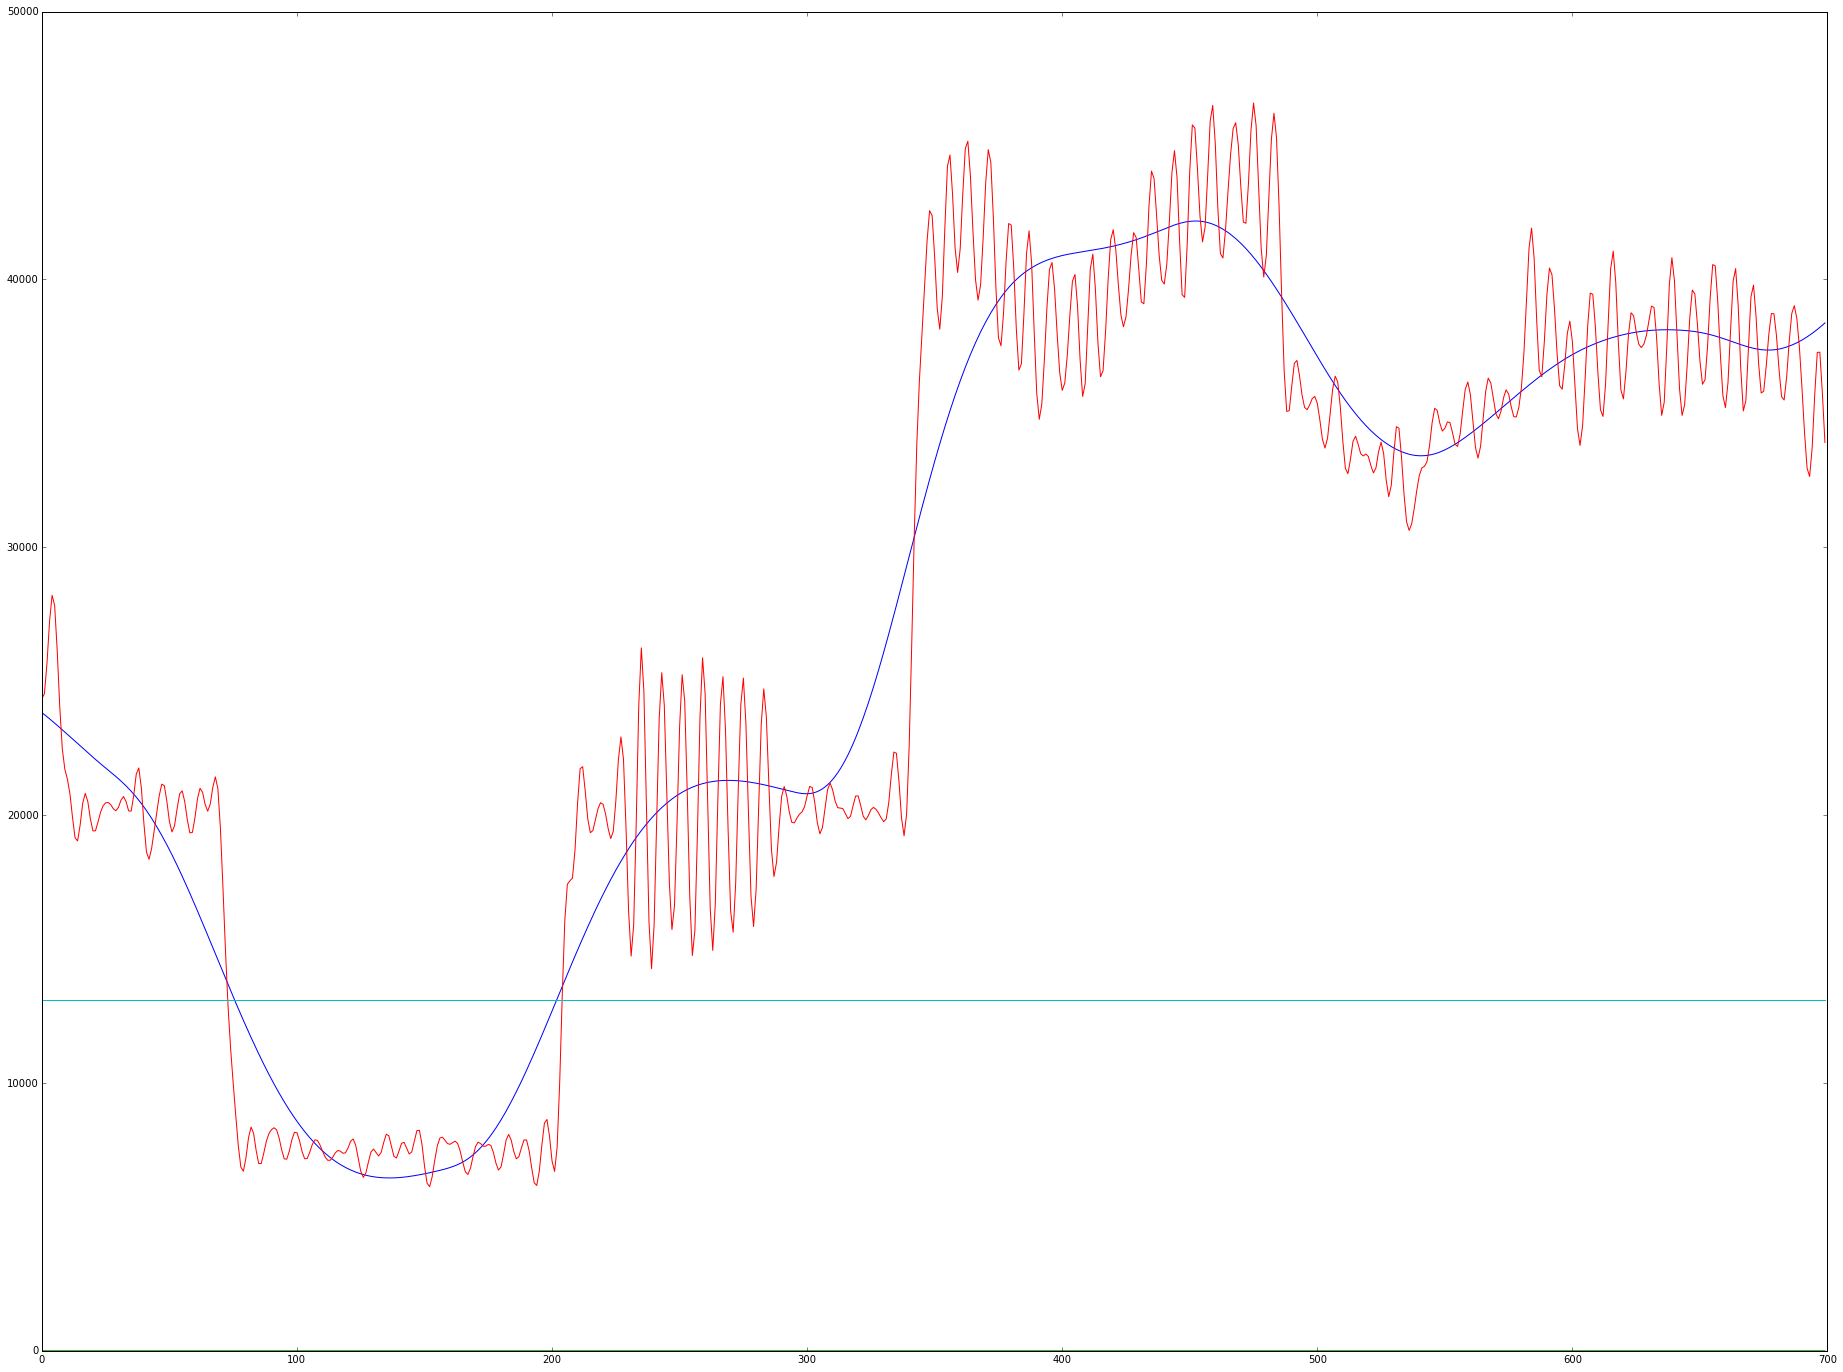

In [77]:
data = data_orig.copy()

# This filter is calibrated to bottom out at approx the middle of a regular HSYNC at about IRE -35,
# and cross over the unfiltered data at approx IRE -20.  Being analog data, this is of course a 
# bit fuzzy, especially when we hit rot.

#f_slpf_b, f_slpf_a = sps.butter(3, 400000 / freq_hz)
f_splf_b = sps.firwin(49, 100000/freq_hz)
f_splf_a = [1.0]
f_slpf_offset = 48

lpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]

synctrig = IREToRaw(-20)

#plt.plot(lpfdata[50300:51000])
#plt.plot(lpfdata[50300:51000] < synctrig)
#plt.plot(data[50300:51000])
#plt.plot(np.full(700, synctrig, dtype=np.float32))
#plt.plot(np.full(700, IREToRaw(-35), dtype=np.float32))

In [78]:
synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-60) # should only happen during rot
#sdata = np.logical_and(data < synctrig, data > rot_lowtrig)
sdata = lpfdata < synctrig

In [79]:
Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
    return np.where(dpeaks)[0] 
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [81]:
def findsyncs(data, diag=False):
    # Parameters
    synctrig = IREToRaw(-20) # this value should be below any likely colorburst for NTSC
    hslen = range(FSC * 14, FSC * 17) # typical range of horizontal syncs at synctrig level
    scanlength = int(FSC * (227.5 * 1.25)) # long enough to cover an entire line, but not long enough to see the half-line hsync as well
    
    sdata = lpfdata < synctrig
    sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
    
    peaks = findpeaks(sfdata)

    vsyncs = []
    cvsync = None
    
    if diag:
        plt.plot(sfdata[54000:57000] * 65535)
        plt.plot(data[54000:57000])
        plt.plot(lpfdata[54000:57000])
        plt.plot(np.full(3000, IREToRaw(120), dtype=np.float32))
        plt.plot(np.full(3000, IREToRaw(-45), dtype=np.float32))
        plt.plot(np.full(3000, synctrig, dtype=np.float32))
    
    # we need to detect the gaps before/after the last full vsync pulse to the prev/next regular hsync,
    # to see which kind of field we're dealing with
    previ = 0
    prevv = 0
    for i in peaks:
        if sfdata[i] > 0.5:
            if previ == None:
                return (1820 * 500), None, None
            
            if len(vsyncs) == 0 or cvsync['gap2'] is not None:
                cvsync = {'hsyncs': [], 'gap1': (i - previ), 'gap2': None}
                vsyncs.append(cvsync)
            
            prevv = i
        elif sfdata[i] > 0.25:
            if cvsync is not None:
                if cvsync['gap2'] is None:
                    cvsync['gap2'] = i - prevv
                    
                cvsync['hsyncs'].append(i)
                
            previ = i
    
    # return a few lines back before the last vsync, so the next read can start correctly
    return vsyncs[-2]['hsyncs'][-3], vsyncs, sfdata

from datetime import datetime
ts = datetime.now()
rlen, peaks, sfdata = findsyncs(data, diag = False)
print(datetime.now() - ts)

0:00:00.138804


In [83]:

def adjust_hsyncs_p1(hsyncs_orig):
    hsyncs = hsyncs_orig.copy()
    hsd = np.diff(hsyncs)
    
    noterr = []

    for i in range(3, len(hsyncs)):
#    for i in [11]:
        hsync = hsyncs[i]
        
#        plt.plot(data[hsync:hsync + 100])
#        plt.plot(lpfdata[hsync:hsync + 100])
#        plt.plot(np.full(100, IREToRaw(-30), dtype=np.float32))
        
        crossp_array = np.logical_and(lpfdata[hsync:hsync + 80] < data[hsync: hsync+80], lpfdata[hsync:hsync + 80] > IREToRaw(-30))
        
        crosspoint = np.argmax(crossp_array)
        print(i, crosspoint)
        
        hsyncs[i] -= (58 - crosspoint)
        
            
    return hsyncs

    

3
3 57
4 57
5 58
6 57
7 58
8 58
9 58
10 56
11 60
12 59
13 59
14 58
15 58
16 59
17 58
18 59
19 58
20 58
21 58
22 58
23 59
24 58
25 59
26 58
27 59
28 58
29 59
30 59
31 58
32 60
33 59
34 60
35 60
36 59
37 60
38 61
39 60
40 60
41 60
42 61
43 58
44 59
45 59
46 58
47 58
48 58
49 59
50 56
51 57
52 58
53 58
54 59
55 58
56 59
57 59
58 59
59 59
60 60
61 59
62 59
63 59
64 60
65 60
66 59
67 61
68 45
69 61
70 60
71 60
72 59
73 59
74 59
75 59
76 58
77 58
78 59
79 59
80 60
81 60
82 59
83 59
84 60
85 60
86 61
87 60
88 54
89 60
90 60
91 60
92 61
93 60
94 60
95 60
96 61
97 61
98 60
99 60
100 60
101 61
102 61
103 60
104 60
105 60
106 61
107 61
108 61
109 61
110 60
111 60
112 61
113 61
114 61
115 61
116 60
117 61
118 60
119 61
120 61
121 61
122 61
123 61
124 60
125 61
126 62
127 61
128 61
129 61
130 61
131 61
132 61
133 61
134 61
135 60
136 60
137 61
138 60
139 60
140 61
141 61
142 61
143 62
144 61
145 61
146 69
147 61
148 61
149 61
150 61
151 60
152 60
153 61
154 61
155 74
156 60
157 61
158 61
159 61
160

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


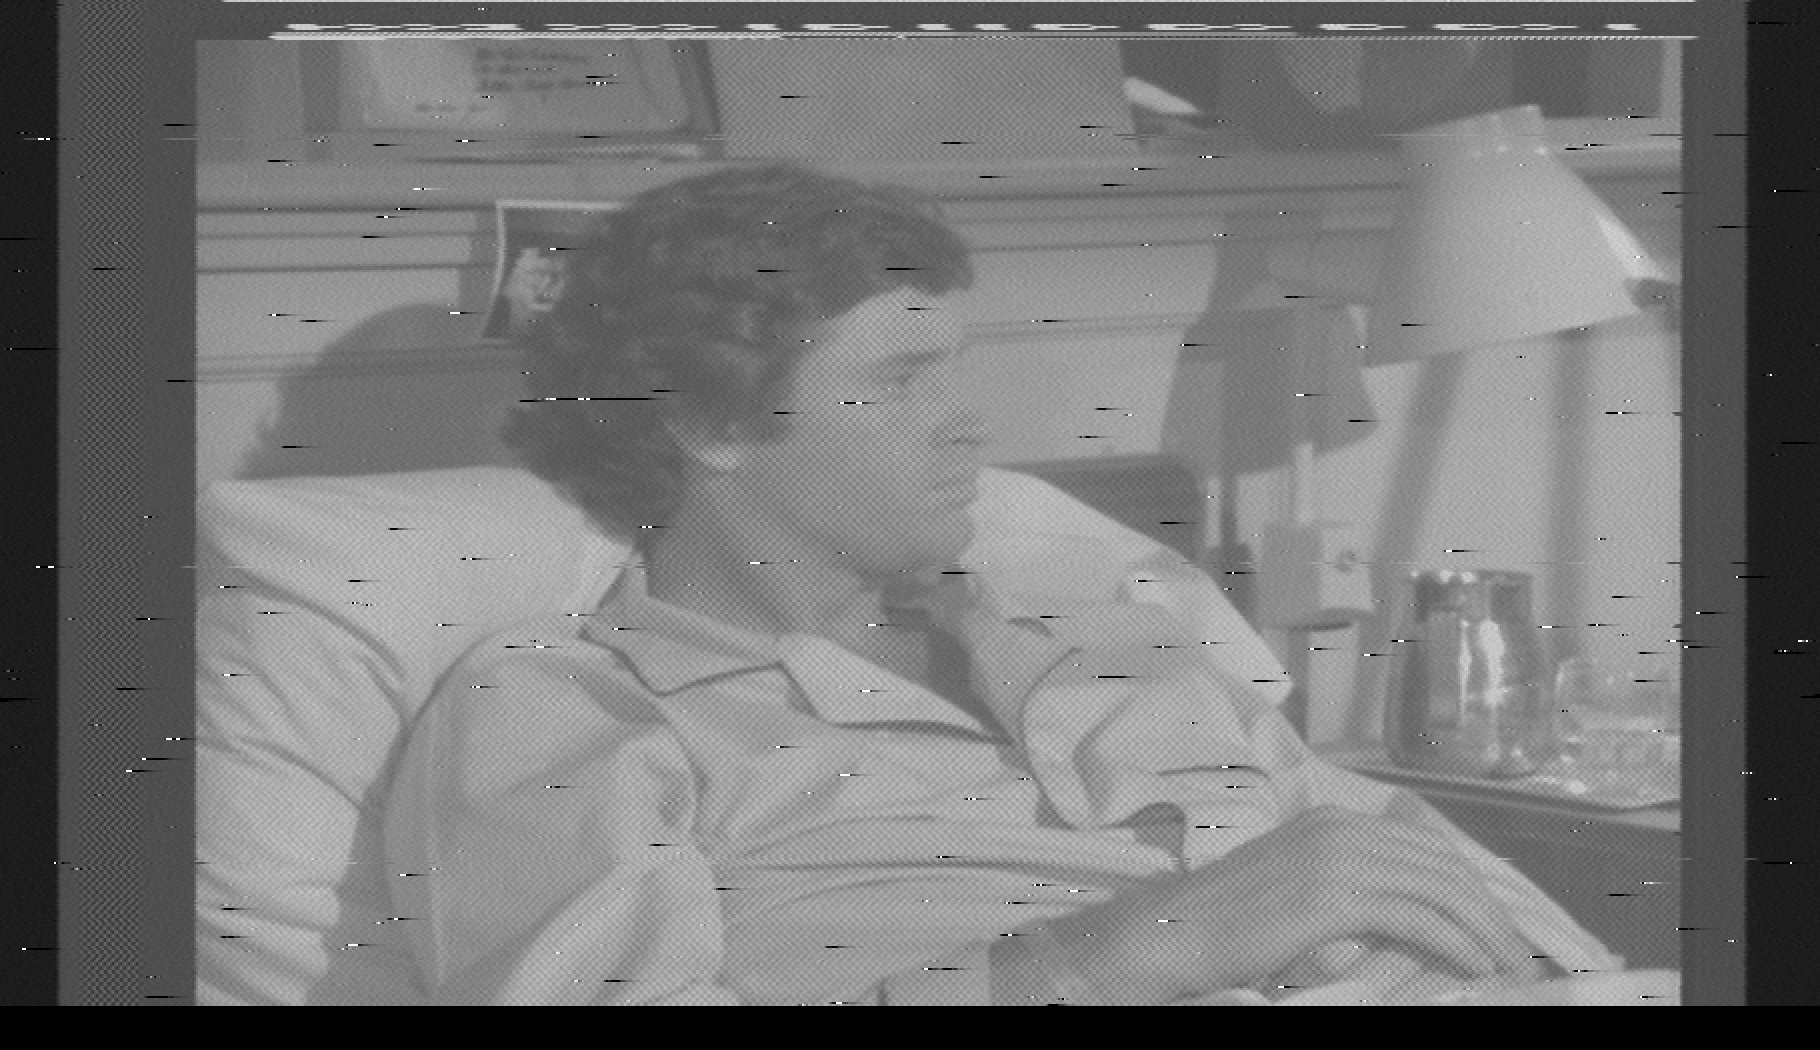

In [109]:
rlen, peaks, sfdata = findsyncs(data)
for i in range(3, 5):
    print(i)
    peaks[i]['hsyncs'] = adjust_hsyncs_p1(peaks[i]['hsyncs'])       

    
for i in range(3, 5):
    print(i)
    #peaks[i]['hsyncs'] = adjust_hsyncs_p2(peaks[i]['hsyncs'])  
    
frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [39]:
sps.firwin?

In [87]:
peaks_tmp = peaks.copy()

In [110]:
#rlen, peaks, sfdata = findsyncs(data)
#peaks_tmp = peaks.copy()

def get_phases(field, line):
    linestart = field['hsyncs'][line]

    line2_postcb = ((field['hsyncs'][line + 1] - linestart) * (260/227.5)) + linestart
    lx = scale(data, linestart, line2_postcb, 260 * out_fsc)
    #framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

    phase1 = burst_detect(lx[32:86])[1]
    phase2 = burst_detect(lx[32+(4*227):86+(4*227)])[1]
    
    return phase1, phase2

def adjust_line(field, line):
    phase1, phase2 = get_phases(field, line)
    #print(phase1, phase2)

    ptgt = np.pi if (np.fabs(phase1) > (np.pi/2)) else 0

    adj2 = phasemult * wrap_angle(phase2, phase1)
    field['hsyncs'][line + 1] += adj2
    
    phase1, phase2 = get_phases(field, line)
    #print(phase1, phase2)
    
    adj1 = phasemult * wrap_angle(phase1, ptgt)
    field['hsyncs'][line] += adj1
    
    phase1, phase2 = get_phases(field, line)
    #print(phase1, phase2)

    adj2 = phasemult * wrap_angle(phase2, ptgt)
    field['hsyncs'][line + 1] += adj2
    
    phase1, phase2 = get_phases(field, line)
    print(line, phase1, phase2)

for i in range(len(peaks[3]['hsyncs'])):
    adjust_line(peaks[3], i)

for i in range(len(peaks[4]['hsyncs'])):
    adjust_line(peaks[4], i)


0 3.11617314688 3.12683635834
1 0.00667702114344 0.0102655185849
2 -3.14094341477 3.12339172891
3 0.00089816320032 0.0778469698915
4 3.13327981275 3.13812663765
5 0.00377980116146 0.0605948431009
6 -3.1408262289 -3.13448952785
7 0.00290164395264 0.00438692717349
8 3.13775158941 -3.07995686802
9 -0.0021741306873 -0.00087706727881
10 3.12318515254 -3.13793527931
11 -0.00358309346145 0.0112740080689
12 -3.13834056755 -3.12604056244
13 -0.00311845298981 0.0113971331261
14 3.13215011364 -3.13847867794
15 -0.0336123889525 0.0585562266403
16 3.14121100842 -3.13298374534
17 0.000991579157892 -0.000532254265484
18 -3.14059858552 -3.05132403265
19 0.000299591625378 -0.000305620866108
20 3.1413054843 -3.11476236978
21 8.89410900908e-05 0.0108262247926
22 3.12986061335 3.13590251408
23 0.000752126035955 -0.00622975036775
24 3.14036117242 3.13237795861
25 0.0078625943589 0.0269688568288
26 3.13921005798 -3.12369633564
27 -0.00422745235922 0.0180101930179
28 3.13554917207 3.13951795524
29 -0.0199808

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: list index out of range

24
(477750,)
uint8 (525, 910) (525, 910)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


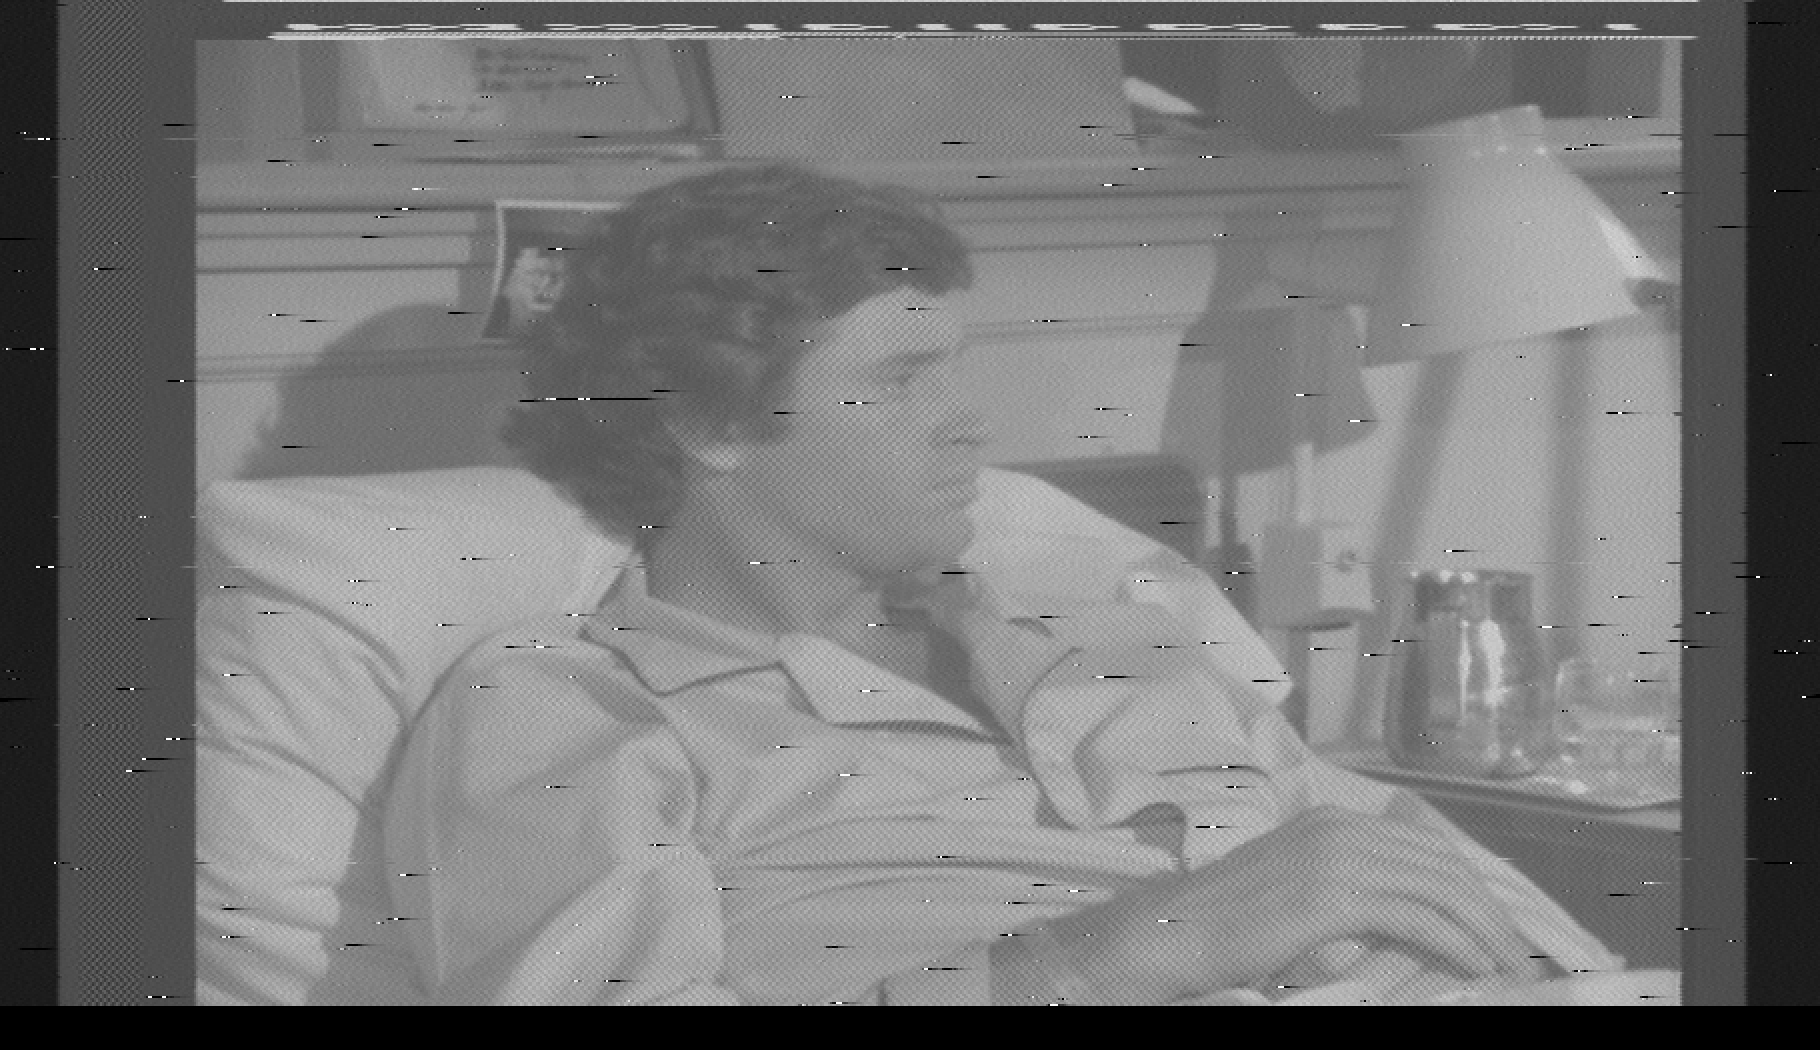

In [111]:
frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)